In [1]:
%matplotlib inline
%load_ext autotime
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Modelling the COVID spread with a SIR model


$$\frac{dS}{dt} = -\beta IS$$

$$\frac{dI}{dt} = \beta IS-\gamma I$$

$$\frac{dR}{dt} = \gamma I$$

In [6]:
START_DATE = {
  'Japan': '1/22/20',
  'Italy': '1/31/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20'
}

time: 997 µs


In [12]:
class Learner(object):
    def __init__(self, country, loss):
        self.country = country
        self.loss = loss
        data = self.load_confirmed(self.country)
        self.data = data
        nthCase = 100 #minimum number of cases to start modelling 

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('time_series_covid19_confirmed_global.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        
        beta = self.beta
        gamma = self.gamma
        data = self.data
        
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    
    def estimate(self):
        
        data=self.data
        
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        print("Beta:{beta} Gamma:{gamma}".format(beta=beta,gamma=gamma))
        self.beta = beta
        self.gamma = gamma
        
    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        
        self.estimate()
        
        beta = self.beta
        gamma = self.gamma
        data=self.data
        
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        self.df = df
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        return new_index, extended_actual
        #fig.savefig(f"{self.country}.png")

time: 5.98 ms


In [13]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

time: 998 µs


Beta:0.19130238396459745 Gamma:4.10644995672149e-05


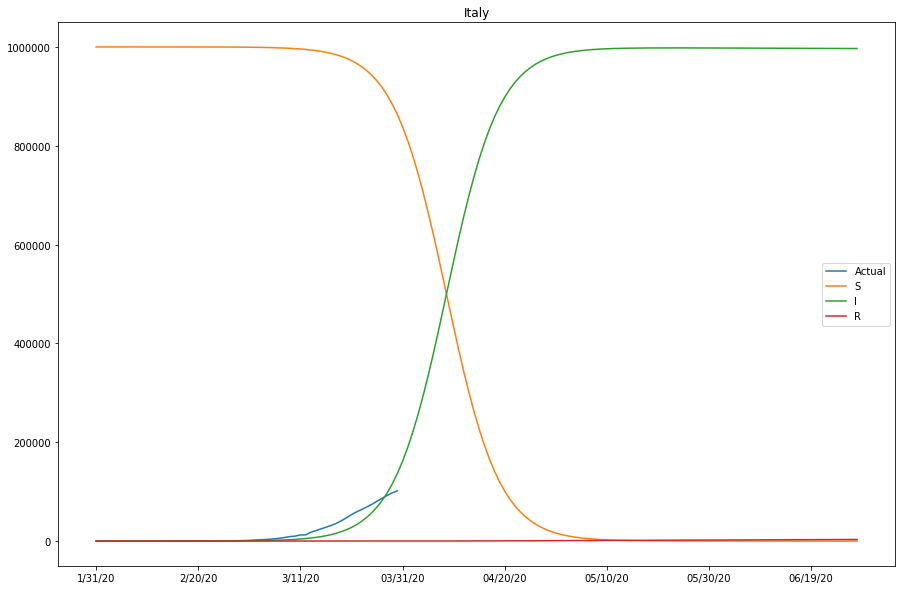

time: 408 ms


In [14]:
N = 1000000
I_0 = 2
S_0 = N - I_0
R_0 = 0

jap = Learner('Italy', loss)
out = jap.train()

In [15]:
jap.df

,Actual,S,I,R
1/31/20,2,999998.000000,2.000000,0.000000
2/1/20,2,999997.578358,2.421551,0.000091
2/2/20,2,999997.067793,2.932007,0.000200
2/3/20,2,999996.449439,3.550228,0.000333
2/4/20,2,999995.701417,4.298089,0.000493
...,...,...,...,...
06/24/20,None,0.462930,996867.102504,3132.434566
06/25/20,None,0.382827,996826.247597,3173.369576
06/26/20,None,0.316715,996785.380377,3214.302908
06/27/20,None,0.261776,996744.503663,3255.234561


time: 13 ms


Next steps:

* Use a better loss function | infected = active cases & recovered = recovered + deaths
* add premise that 100 cases means 200 infected
* sum recoveries and deaths
* start on hundredth case